# Group 7: Final Optimization Formulation and Method In-Progress Notebook
- Group 7: Alan Sam Samuel Daou, Michael Munson, Dharmi Amit Shah, Sanjay Srinivasan

# Auto-Thermal Reformer Dataset
- The source code is modified from https://github.com/cog-imperial/OMLT/blob/main/docs/notebooks/neuralnet/auto-thermal-reformer-relu.ipynb.
- This is the only dataset that must be read in from a .csv.

# BEFORE YOU RUN THIS!!!!
CREATE AN .xlsx FILE IN THE SAME FOLDER AS THIS NOTEBOOK.

Should be called "Book1.xlsx"

In [1]:
# read in our csv data
import pandas as pd

columns = ['Bypass Fraction', 'NG Steam Ratio', 'Steam Flow',
           'Reformer Duty','AR', 'C2H6', 'C3H8', 'C4H10',
           'CH4', 'CO', 'CO2', 'H2', 'H2O', 'N2']

# The pathway might have to change, depending on how you downloaded and extracted the .zip file
df = pd.read_csv('reformer.csv', usecols=columns)
df

,Bypass Fraction,NG Steam Ratio,Steam Flow,Reformer Duty,AR,C2H6,C3H8,C4H10,CH4,CO,CO2,H2,H2O,N2
0,0.8,0.800000,0.193898,9806.732716,0.002662,0.012120,0.002651,0.001515,0.369276,0.073971,0.032251,0.208494,0.070771,0.226288
1,0.8,0.810526,0.196449,9846.047501,0.002660,0.012107,0.002648,0.001513,0.368883,0.073684,0.032432,0.208507,0.071514,0.226050
2,0.8,0.821053,0.199000,9885.419259,0.002657,0.012094,0.002646,0.001512,0.368491,0.073398,0.032612,0.208519,0.072258,0.225813
3,0.8,0.831579,0.201552,9924.849127,0.002654,0.012082,0.002643,0.001510,0.368100,0.073114,0.032791,0.208529,0.073000,0.225577
4,0.8,0.842105,0.204103,9964.338177,0.002651,0.012069,0.002640,0.001509,0.367710,0.072832,0.032968,0.208537,0.073743,0.225341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,0.1,1.157895,1.262887,39771.876388,0.004086,0.000517,0.000113,0.000065,0.016104,0.103440,0.054146,0.330923,0.152351,0.338256
2796,0.1,1.168421,1.274368,39989.582852,0.004080,0.000516,0.000113,0.000064,0.016073,0.103003,0.054335,0.330682,0.153420,0.337714
2797,0.1,1.178947,1.285849,40207.531167,0.004073,0.000515,0.000113,0.000064,0.016043,0.102569,0.054521,0.330439,0.154487,0.337174
2798,0.1,1.189474,1.297330,40425.721366,0.004067,0.000514,0.000112,0.000064,0.016013,0.102138,0.054706,0.330196,0.155552,0.336636


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress CUDA warnings from tensorflow
import sys

# import the necessary packages
from omlt import OmltBlock, OffsetScaling
from omlt.io.keras_reader import load_keras_sequential
from omlt.neuralnet import ReluBigMFormulation, FullSpaceSmoothNNFormulation
import pyomo.environ as pyo
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# separate the data into inputs and outputs
inputs = ['Bypass Fraction', 'NG Steam Ratio'] 
outputs = [ 'Steam Flow', 'Reformer Duty','AR', 'C2H6', 'C3H8', 'C4H10',
           'CH4', 'CO', 'CO2', 'H2', 'H2O', 'N2']
dfin = df[inputs] #copies the columns with the same title as df
dfout = df[outputs]

In [4]:
# We scale the data for improved training, however, we want to formulate
# our optimizaton problem on the original variables. Therefore, we keep
# the scaling parameters to use later in our optimization formulation

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

#scaled using z-score normalization. Puts everything in same order of magnitude
dfin_scaled = (dfin - dfin.mean()).divide(dfin.std()) #Calculates z-score of each value.
dfout_scaled = (dfout - dfout.mean()).divide(dfout.std())

# capture the minimum and maximum values of the scaled inputs
# so we don't use the model outside the valid range
scaled_lb = dfin_scaled.min()[inputs].values
scaled_ub = dfin_scaled.max()[inputs].values

x_scaled = dfin_scaled.values
y_scaled = dfout_scaled.values

In [5]:
from sklearn.model_selection import train_test_split
# implement train/test/split
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(dfin_scaled, dfout_scaled, test_size = 0.10)
y_test = y_test_scaled*y_factor + y_offset

In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_absolute_percentage_error as mape

# instantiate ranges for neural network building
nodes_list = [2, 5, 10, 20]
hidden_layers_list = [1, 2, 4]
activation_list = ['sigmoid','relu']
# for recording data
epoch_loss_df = pd.DataFrame()  #training set loss as model is being optimized
epoch_accuracy_df = pd.DataFrame() # training set accuracy as model is being optimized
stats_df = pd.DataFrame()
y_hat_data = []
ave_error_frame = pd.DataFrame()

# create nn's and save with name format 'dataset, activation, layers, nodes'
for act in activation_list:
    for layers in hidden_layers_list:
        for nodes in nodes_list:
            
            start_time = time.time() #for timing function
            
            # Create NN and name it
            nn_name = 'reformer_{}_{}_{}'.format(act,layers,nodes)
            
            nn_scaled = Sequential(name=nn_name)
            
            # Create input layer
            nn_scaled.add(Dense(units=nodes,input_dim=len(inputs),activation=act))
            
            # Create hidden layers
            for i in range(layers):
                nn_scaled.add(Dense(units=nodes, activation=act))
            
            # Create output layer
            nn_scaled.add(Dense(units=len(outputs)))
            
            # Compile
            nn_scaled.compile(optimizer=Adam(), loss = 'mse', metrics=['accuracy'])
            
            # Train (probably have to change to accomodate x_train, y_train...)
            history_scaled = nn_scaled.fit(x_train_scaled,y_train_scaled,epochs=100, verbose=0)
            
            # Save the Epoch Data
            epoch_loss_df[nn_name]=history_scaled.history['loss']
            epoch_accuracy_df[nn_name]=history_scaled.history['accuracy']
            
            # validate function by predicting scaled values
            y_hat_scaled = nn_scaled.predict(x_test_scaled)
            
            # unscale predictions and store
            y_hat = pd.DataFrame(y_hat_scaled,columns = outputs)*y_factor + y_offset
            y_hat_data.append([nn_name,y_hat])
            
            y = pd.DataFrame(data =y_hat, columns = outputs)
                           
            # find cross validation error...
            y_hat1 = np.asarray(y_hat)
            y_test1 = y_test.to_numpy()
            deviation = np.absolute(np.subtract(y_hat1,y_test1))
            error_percent = (np.divide(deviation,y_test1))*100
            error_frame = pd.DataFrame(error_percent,columns=outputs)
            ave_error_frame[nn_name] = error_frame.mean(axis=0)
            
            # Record complex outputs in excel workbook
            path = 'Book1.xlsx'
            with pd.ExcelWriter(path ,engine="openpyxl",mode='a',if_sheet_exists='replace') as writer:
                y.to_excel(writer, sheet_name=nn_name+'_yh')
                error_frame.to_excel(writer, sheet_name=nn_name+'_er')

            #PYOMO CODE

            # first, create the Pyomo model
            m = pyo.ConcreteModel()

            # create the OmltBlock to hold the neural network model
            m.reformer = OmltBlock()

            # load the Keras model
            nn_reformer = nn_scaled

            # Note: The neural network is in the scaled space. We want access to the
            # variables in the unscaled space. Therefore, we need to tell OMLT about the
            # scaling factors
            scaler = OffsetScaling(
                    offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
                    factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
                    offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
                    factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
                )

            scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

            # create a network definition from the Keras model
            net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

            # create the variables and constraints for the neural network in Pyomo
            if act == 'relu':
                m.reformer.build_formulation(ReluBigMFormulation(net))
            else:
                m.reformer.build_formulation(FullSpaceSmoothNNFormulation(net))
            
            # now add the objective and the constraints
            h2_idx = outputs.index('H2')
            n2_idx = outputs.index('N2')
            m.obj = pyo.Objective(expr=m.reformer.outputs[h2_idx], sense=pyo.maximize) #objective is to maximize hydrogen in syngas
            m.con = pyo.Constraint(expr=m.reformer.outputs[n2_idx] <= 0.34) #constraint that nitrogen composition <=0.34

            # now solve the optimization problem (this may take some time)
            if act == 'relu':
                solver = pyo.SolverFactory("gurobi")
            else:
                solver = pyo.SolverFactory('ipopt')
                
            status = solver.solve(m, tee=False)
            
            # collect optimization data
            headers = ['Optimum Bypass Fraction', 'Optimum NG Steam Ratio', 'Maximum H2 Output', 'Maximum N2 Output', 'Time of Computation']
            stats_df[nn_name] = pd.DataFrame([pyo.value(m.reformer.inputs[0]),pyo.value(m.reformer.inputs[1]),
                                 pyo.value(m.reformer.outputs[h2_idx]), pyo.value(m.reformer.outputs[n2_idx]),
                                 time.time()-start_time], index=headers)

# Explanation of Data Generated

In [7]:
# Loss from training the NN (per epoch)
# The last value is the final loss metric on the training dataset
epoch_loss_df

,reformer_sigmoid_1_2,reformer_sigmoid_1_5,reformer_sigmoid_1_10,reformer_sigmoid_1_20,reformer_sigmoid_2_2,reformer_sigmoid_2_5,reformer_sigmoid_2_10,reformer_sigmoid_2_20,reformer_sigmoid_4_2,reformer_sigmoid_4_5,...,reformer_relu_1_10,reformer_relu_1_20,reformer_relu_2_2,reformer_relu_2_5,reformer_relu_2_10,reformer_relu_2_20,reformer_relu_4_2,reformer_relu_4_5,reformer_relu_4_10,reformer_relu_4_20
0,1.039741,1.222001,1.030410,1.025652,1.048637,1.046278,1.033539,1.025488,1.052078,1.042870,...,0.848975,0.727342,1.048063,0.971022,0.880542,0.793144,0.990062,0.959024,0.906929,0.707971
1,1.008143,1.073702,0.952411,0.910763,1.011533,0.991677,0.988772,0.983576,1.014653,0.998698,...,0.491352,0.238641,0.996542,0.791476,0.409709,0.140602,0.980059,0.695374,0.398242,0.057518
2,0.989096,1.005024,0.888359,0.761841,0.996514,0.976523,0.978848,0.959017,1.000531,0.992269,...,0.220744,0.067461,0.988650,0.466786,0.107532,0.024128,0.951602,0.321737,0.140975,0.011057
3,0.972224,0.960695,0.782811,0.484556,0.989919,0.963178,0.959271,0.871865,0.994981,0.991389,...,0.110663,0.029629,0.979816,0.247717,0.046328,0.014407,0.881875,0.163040,0.084209,0.005716
4,0.951234,0.918179,0.608369,0.234565,0.985100,0.939799,0.901553,0.570391,0.992624,0.991186,...,0.062574,0.018976,0.945503,0.161453,0.028140,0.009785,0.743540,0.114579,0.055900,0.003915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.048575,0.008463,0.000831,0.000254,0.091893,0.008685,0.000889,0.000195,0.091685,0.069858,...,0.000511,0.000114,0.084996,0.002677,0.000265,0.000088,0.104085,0.001567,0.000252,0.000227
96,0.048012,0.008085,0.000822,0.000257,0.091800,0.008363,0.000855,0.000180,0.091738,0.069781,...,0.000499,0.000101,0.085010,0.002662,0.000250,0.000087,0.104172,0.001532,0.000290,0.000122
97,0.047382,0.007716,0.000788,0.000252,0.091569,0.008038,0.000816,0.000167,0.091405,0.069715,...,0.000503,0.000098,0.084921,0.002644,0.000263,0.000089,0.104144,0.001556,0.000237,0.000141
98,0.046824,0.007315,0.000779,0.000232,0.091472,0.007703,0.000829,0.000169,0.091143,0.069702,...,0.000533,0.000108,0.084882,0.002648,0.000257,0.000093,0.104172,0.001605,0.000249,0.000128


In [8]:
# Accuracy from training the NN (per epoch)
# The last value is the final accuracy metric on the training dataset
epoch_accuracy_df

,reformer_sigmoid_1_2,reformer_sigmoid_1_5,reformer_sigmoid_1_10,reformer_sigmoid_1_20,reformer_sigmoid_2_2,reformer_sigmoid_2_5,reformer_sigmoid_2_10,reformer_sigmoid_2_20,reformer_sigmoid_4_2,reformer_sigmoid_4_5,...,reformer_relu_1_10,reformer_relu_1_20,reformer_relu_2_2,reformer_relu_2_5,reformer_relu_2_10,reformer_relu_2_20,reformer_relu_4_2,reformer_relu_4_5,reformer_relu_4_10,reformer_relu_4_20
0,0.075397,0.033730,0.261905,0.029365,0.040873,0.000000,0.010714,0.206349,0.163889,0.019841,...,0.392063,0.247222,0.170238,0.045635,0.151190,0.434127,0.203968,0.064683,0.123413,0.292460
1,0.075397,0.033730,0.272619,0.215476,0.040873,0.000000,0.184921,0.136111,0.163889,0.045238,...,0.350000,0.251190,0.184921,0.063889,0.175794,0.413095,0.232143,0.016270,0.168254,0.491270
2,0.074603,0.033730,0.276190,0.357143,0.067460,0.000000,0.048413,0.114683,0.163889,0.019841,...,0.321825,0.324603,0.184921,0.048016,0.332143,0.543651,0.315476,0.151190,0.081349,0.684127
3,0.054365,0.033730,0.129365,0.317857,0.193254,0.183730,0.047222,0.158333,0.055556,0.019841,...,0.351587,0.492857,0.184127,0.041270,0.442063,0.607143,0.356746,0.167460,0.180556,0.671032
4,0.150000,0.033730,0.076984,0.305952,0.263095,0.320238,0.048413,0.188095,0.113492,0.032937,...,0.405556,0.566270,0.186905,0.044444,0.470238,0.679365,0.387302,0.295635,0.353175,0.625397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.296032,0.556746,0.617857,0.695238,0.090873,0.537302,0.758333,0.697222,0.102778,0.203175,...,0.636508,0.727381,0.157937,0.763095,0.670635,0.722222,0.173016,0.601587,0.681349,0.701984
96,0.297222,0.556349,0.623810,0.696825,0.087698,0.539286,0.757937,0.702778,0.105556,0.209921,...,0.636905,0.730159,0.153968,0.774603,0.680159,0.729762,0.182143,0.603571,0.687302,0.707540
97,0.305159,0.557936,0.620635,0.701190,0.091270,0.542063,0.760714,0.707937,0.105952,0.207143,...,0.640476,0.729762,0.155952,0.762698,0.675000,0.724206,0.172619,0.607937,0.680952,0.704762
98,0.314286,0.559524,0.625794,0.702778,0.090873,0.546032,0.761508,0.705952,0.105159,0.213492,...,0.636111,0.720238,0.159524,0.757937,0.671825,0.717857,0.173810,0.601984,0.692460,0.705952


In [9]:
# Reports the optimized values per NN
stats_df

,reformer_sigmoid_1_2,reformer_sigmoid_1_5,reformer_sigmoid_1_10,reformer_sigmoid_1_20,reformer_sigmoid_2_2,reformer_sigmoid_2_5,reformer_sigmoid_2_10,reformer_sigmoid_2_20,reformer_sigmoid_4_2,reformer_sigmoid_4_5,...,reformer_relu_1_10,reformer_relu_1_20,reformer_relu_2_2,reformer_relu_2_5,reformer_relu_2_10,reformer_relu_2_20,reformer_relu_4_2,reformer_relu_4_5,reformer_relu_4_10,reformer_relu_4_20
Optimum Bypass Fraction,0.169919,0.100000,0.100000,0.100000,0.201152,0.100000,0.100000,0.100000,0.187940,0.244258,...,0.100000,0.100000,0.169105,0.100000,0.100000,0.100000,0.320287,0.100000,0.100000,0.100000
Optimum NG Steam Ratio,1.199996,1.080267,1.116719,1.118287,1.036982,1.105557,1.122386,1.111596,1.058752,1.199755,...,1.135489,1.127108,0.800000,1.169390,1.138136,1.110915,1.200000,1.144919,1.136968,1.123729
Maximum H2 Output,0.329038,0.333327,0.331992,0.331699,0.327983,0.333075,0.331966,0.331161,0.327713,0.328730,...,0.332323,0.332397,0.327299,0.333440,0.331571,0.331888,0.327781,0.332306,0.332153,0.332024
Maximum N2 Output,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,...,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000
Time of Computation,4.831046,4.273208,4.810357,5.017930,4.726501,4.799134,5.173570,5.970437,5.565205,5.917688,...,6.023253,6.778022,6.495798,6.712106,6.921217,8.054362,7.571008,7.839612,7.689789,16.527646


In [10]:
# Testing dataset, for parity plot
y_test

,Steam Flow,Reformer Duty,AR,C2H6,C3H8,C4H10,CH4,CO,CO2,H2,H2O,N2
2225,0.785723,26210.179976,0.003849,0.002731,0.000597,0.000341,0.083534,0.100064,0.049032,0.308905,0.131200,0.319747
850,0.686851,24559.646373,0.003948,0.002683,0.000587,0.000335,0.082157,0.106633,0.046159,0.312474,0.117152,0.327871
547,0.501772,18797.891191,0.003688,0.004659,0.001019,0.000582,0.142285,0.100455,0.042937,0.290999,0.106001,0.307375
1159,0.943145,31774.989208,0.004077,0.001322,0.000289,0.000165,0.040689,0.107435,0.049972,0.325643,0.132511,0.337897
336,0.425215,15790.391815,0.003347,0.006703,0.001466,0.000838,0.204407,0.088913,0.042034,0.266517,0.105606,0.280169
...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.449027,16496.383314,0.003408,0.006259,0.001369,0.000782,0.190909,0.090558,0.042634,0.271448,0.107561,0.285070
942,0.673429,25147.383515,0.004069,0.002212,0.000484,0.000276,0.067882,0.112426,0.044855,0.319392,0.110678,0.337726
2090,0.729890,24047.744644,0.003709,0.003525,0.000771,0.000441,0.107652,0.095140,0.048831,0.299037,0.132338,0.308556
2584,1.008480,33325.350615,0.004071,0.001169,0.000256,0.000146,0.036003,0.106119,0.051030,0.326410,0.137472,0.337324


In [11]:
# Predicted dataset, for parity plot
# This is also recorded in the excel workbook with sheets labeled '..._yh'
df = pd.read_excel('Book1.xlsx', sheet_name='reformer_relu_2_10_yh')
df

,Unnamed: 0,Steam Flow,Reformer Duty,AR,C2H6,C3H8,C4H10,CH4,CO,CO2,H2,H2O,N2
0,0,0.796607,26386.424047,0.003844,0.002701,0.000606,0.000341,0.082988,0.099848,0.049146,0.308976,0.131822,0.319290
1,1,0.678897,24381.709937,0.003944,0.002699,0.000597,0.000332,0.083697,0.106484,0.046050,0.311651,0.117059,0.327472
2,2,0.495576,18720.596798,0.003683,0.004700,0.001024,0.000592,0.142898,0.100405,0.042930,0.291062,0.105727,0.307184
3,3,0.946126,31852.300217,0.004076,0.001326,0.000294,0.000169,0.040595,0.107637,0.049824,0.325736,0.132370,0.337880
4,4,0.425243,15838.952189,0.003344,0.006734,0.001465,0.000841,0.205036,0.088854,0.041975,0.266226,0.105816,0.279999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,275,0.450053,16559.005892,0.003415,0.006231,0.001353,0.000778,0.189713,0.090734,0.042674,0.271882,0.108101,0.285658
276,276,0.668445,25051.164382,0.004067,0.002234,0.000490,0.000275,0.069217,0.112203,0.044887,0.318912,0.110461,0.337439
277,277,0.732810,24050.269769,0.003716,0.003500,0.000755,0.000431,0.106716,0.095095,0.048879,0.298875,0.132754,0.308812
278,278,1.011137,33423.862260,0.004069,0.001183,0.000259,0.000150,0.036344,0.106209,0.050915,0.326328,0.137391,0.337251


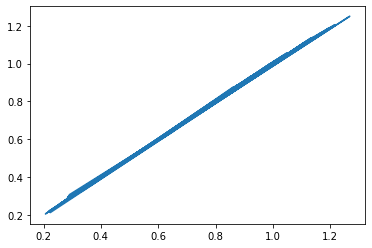

In [12]:
import pylab as plt

plt.plot(y_test['Steam Flow'], df['Steam Flow'])
#probably add the r2 metric to see if "good linear fit", closer to 1 means good predictor.

In [13]:
# Cross validation metric: Average percent error per output characteristic
ave_error_frame

,reformer_sigmoid_1_2,reformer_sigmoid_1_5,reformer_sigmoid_1_10,reformer_sigmoid_1_20,reformer_sigmoid_2_2,reformer_sigmoid_2_5,reformer_sigmoid_2_10,reformer_sigmoid_2_20,reformer_sigmoid_4_2,reformer_sigmoid_4_5,...,reformer_relu_1_10,reformer_relu_1_20,reformer_relu_2_2,reformer_relu_2_5,reformer_relu_2_10,reformer_relu_2_20,reformer_relu_4_2,reformer_relu_4_5,reformer_relu_4_10,reformer_relu_4_20
Steam Flow,8.549326,4.253739,0.968980,0.592483,11.185945,5.921785,1.190367,0.397020,10.943078,6.924889,...,1.257713,0.416946,12.642129,2.195540,0.755593,0.380897,9.666183,2.743183,0.671211,0.352461
Reformer Duty,7.557062,4.698458,0.823441,0.544275,8.834848,6.056144,0.932368,0.380827,8.526367,2.420941,...,0.742514,0.275506,9.526742,2.017223,0.626434,0.306139,6.722947,1.983226,0.590504,0.293088
AR,2.115189,0.578726,0.291075,0.124263,2.654293,0.550951,0.260982,0.113136,2.613566,2.213929,...,0.215359,0.099196,2.424447,0.496147,0.139489,0.133312,2.953522,0.380363,0.128394,0.092573
C2H6,13.041452,4.844365,1.543023,0.761407,10.164012,3.217827,2.036818,1.021750,10.901028,9.572095,...,1.563012,0.691048,9.660947,4.675897,0.877999,1.578070,18.433869,3.394171,1.278642,1.253322
C3H8,12.912516,3.684133,1.464730,0.802387,10.062540,3.594624,1.782726,0.825359,10.828044,9.852181,...,1.616979,0.788810,11.204331,4.676116,1.412528,1.601738,18.434002,3.672966,1.442235,1.034372
C4H10,12.569353,3.818024,1.462539,0.743422,10.049300,4.674840,1.827764,0.686551,10.928129,10.057669,...,1.657204,0.829948,9.984141,4.676851,1.345658,1.794742,18.433949,3.343782,1.094842,1.214959
CH4,12.683717,3.850100,1.480728,0.818927,9.962761,4.577312,1.409883,0.790367,10.548939,9.823855,...,1.789607,0.934804,10.353539,4.615419,0.909797,1.458218,18.187858,3.294309,1.411858,0.895019
CO,2.958144,0.648118,0.344054,0.178153,5.001048,0.636377,0.354765,0.125029,4.946206,4.769944,...,0.251264,0.103609,4.845463,0.524554,0.173120,0.162907,5.148423,0.479781,0.154790,0.135013
CO2,2.059635,0.878985,0.264670,0.164612,3.775251,0.768274,0.289283,0.131479,3.811817,3.522593,...,0.189511,0.111537,3.668458,0.466118,0.169049,0.107761,3.907258,0.369272,0.151479,0.094002
H2,1.891140,0.641648,0.274245,0.120223,1.884787,0.603539,0.232560,0.111795,1.874230,1.359868,...,0.206476,0.099590,1.598488,0.495262,0.129009,0.139785,2.410564,0.325349,0.161275,0.092141


In [30]:
ave_error_frame.loc["Steam Flow"][4:8]

reformer_sigmoid_2_2     11.185945
reformer_sigmoid_2_5      5.921785
reformer_sigmoid_2_10     1.190367
reformer_sigmoid_2_20     0.397020
Name: Steam Flow, dtype: float64

In [34]:
ave_error_frame['reformer_relu_4_20']['Steam Flow']

0.3524606755048104

In [14]:
# Cross validation metric: Percent error per POINT per characteristic
# This is NOT complete in this code
# The complete data is in the excel workbook, on sheets '..._er'
error_frame

,Steam Flow,Reformer Duty,AR,C2H6,C3H8,C4H10,CH4,CO,CO2,H2,H2O,N2
0,0.422808,0.033081,0.024036,0.598965,0.668927,0.428657,0.422152,0.095179,0.002030,0.102423,0.176406,0.108891
1,0.251356,0.200612,0.086298,0.807305,1.479199,0.730373,0.592862,0.008882,0.146676,0.103118,0.213728,0.083320
2,0.294825,0.048048,0.064248,0.554115,0.236803,0.636312,0.236723,0.040606,0.063504,0.069016,0.221721,0.130235
3,0.123476,0.007211,0.032782,0.025761,0.750087,3.247408,2.102242,0.091674,0.125441,0.107650,0.134312,0.065328
4,0.007975,0.333234,0.064515,0.172180,0.546831,0.792673,0.595055,0.138002,0.213650,0.020196,0.286778,0.031199
...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.056187,0.357650,0.004893,0.200217,0.509633,1.163121,0.600832,0.119000,0.253728,0.075543,0.523501,0.031519
276,0.092271,0.235001,0.083117,0.361406,0.843367,1.164827,1.056142,0.097792,0.061726,0.055729,0.142205,0.016168
277,0.361771,0.189663,0.050042,0.069380,0.190892,0.306870,0.278948,0.021334,0.085554,0.035215,0.010850,0.031419
278,0.097579,0.097376,0.092459,2.852214,1.418450,4.794008,3.435871,0.211234,0.136544,0.069078,0.180738,0.127208


# Analysis / Data Format

### Plot of "ave_error_frame"
- Plot ave error of a characteristic vs # nodes
    - Each new line is for a different activation / # hidden layers
    - Does the trend go lower the more nodes we add?
        - Seems to!
    - Does the trend go lower the more layers we add?
        - Seems to NOT be the case, maybe a case for overfitting!
        - 4 layers did worse than 2 layers
    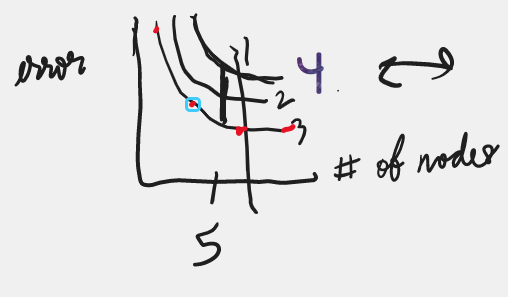
    
- Plot ave error of a characteristic vs activation function
    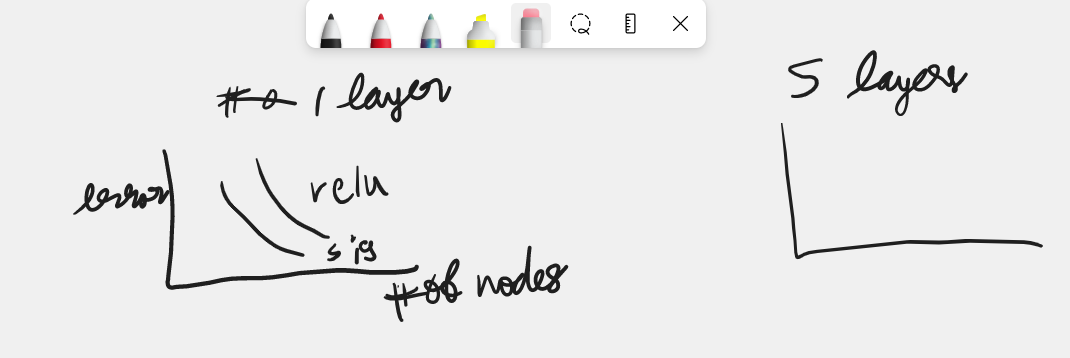
    - Does the activation function seem to affect the error

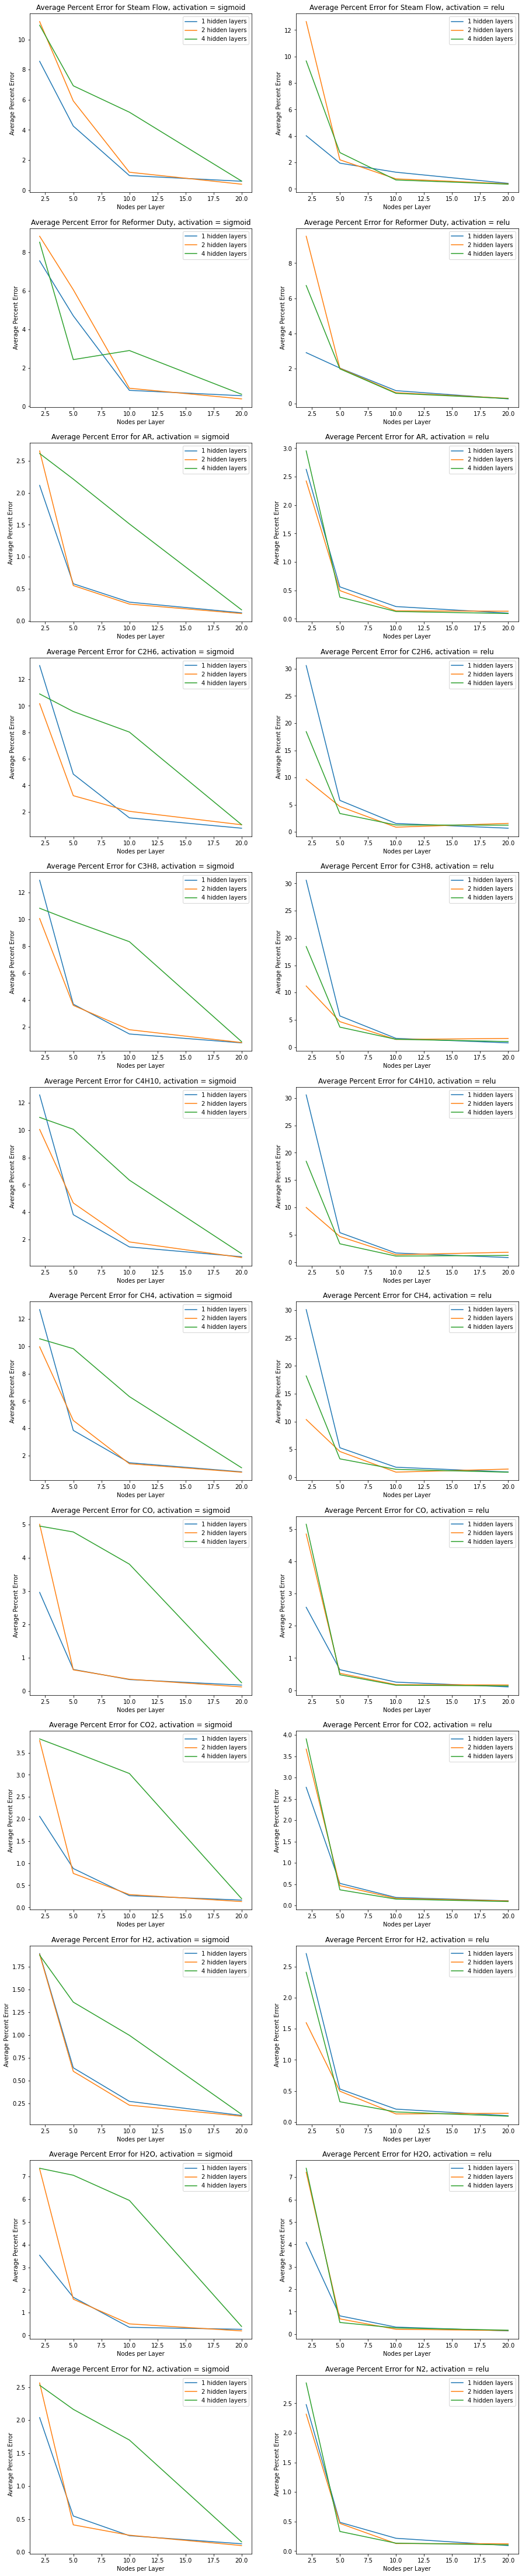

In [68]:
# Create Graphs
fig, axs = plt.subplots(len(outputs),len(activation_list), figsize = (15,80))

# Grab and graph the data vs y_test
for j, act in enumerate(activation_list):
    for i, output in enumerate(outputs):
        for layers in hidden_layers_list:
            error = []
            for nodes in nodes_list:

                # Create NN and name it
                nn_name = 'reformer_{}_{}_{}'.format(act,layers,nodes)

                # Grab Data
                error.append(ave_error_frame[nn_name][output])
            
            axs[i,j].plot(nodes_list, error, label = '{} hidden layers'.format(layers))

#Create labels and titles for graphs
for i, output in enumerate(outputs):
    for j, act in enumerate(activation_list):
        axs[i,j].legend()
        axs[i,j].set_xlabel('Nodes per Layer')
        axs[i,j].set_ylabel('Average Percent Error')
        axs[i,j].set_title("Average Percent Error for {}, activation = {}".format(output, act))

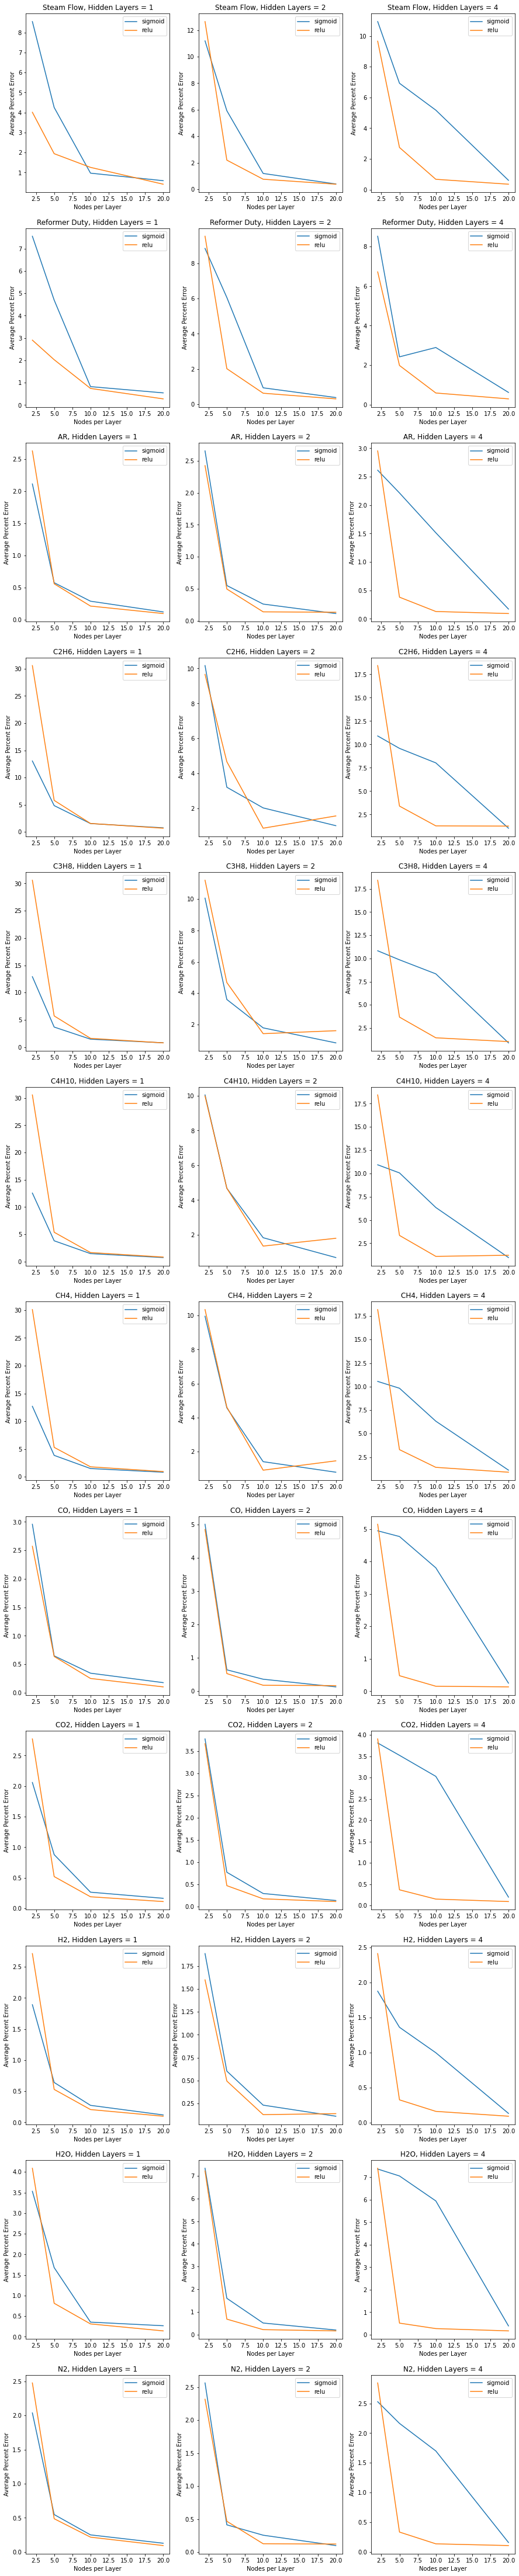

In [67]:
# Create Graphs
fig, axs = plt.subplots(len(outputs),len(hidden_layers_list), figsize = (15,80))

# Grab and graph the data vs y_test
for i, output in enumerate(outputs):
    for j, layers in enumerate(hidden_layers_list):
        for act in activation_list:
            error = []
            for nodes in nodes_list:

                # Create NN and name it
                nn_name = 'reformer_{}_{}_{}'.format(act,layers,nodes)

                # Grab Data
                error.append(ave_error_frame[nn_name][output])
            
            axs[i,j].plot(nodes_list, error, label = '{}'.format(act))

#Create labels and titles for graphs
for i, output in enumerate(outputs):
    for j, layers in enumerate(hidden_layers_list):
        axs[i,j].legend()
        axs[i,j].set_xlabel('Nodes per Layer')
        axs[i,j].set_ylabel('Average Percent Error')
        axs[i,j].set_title("{}, Hidden Layers = {}".format(output, layers))

### Parity Plots of all outputs
- y_actual vs y_predicted
- Ex. on one graph, we want "AR_actual" vs "AR_predicted" (__finished__)
    - Graph so we can compare all NN-architectures
- Show r2 (__finished__)
- Maybe we see that the larger the network, the closer it tends to be towards the actual...
- Maybe we see that a certain activation function creates predictions closer to the actual.

- Overall goal of parity plots... How good of a fit is a NN?

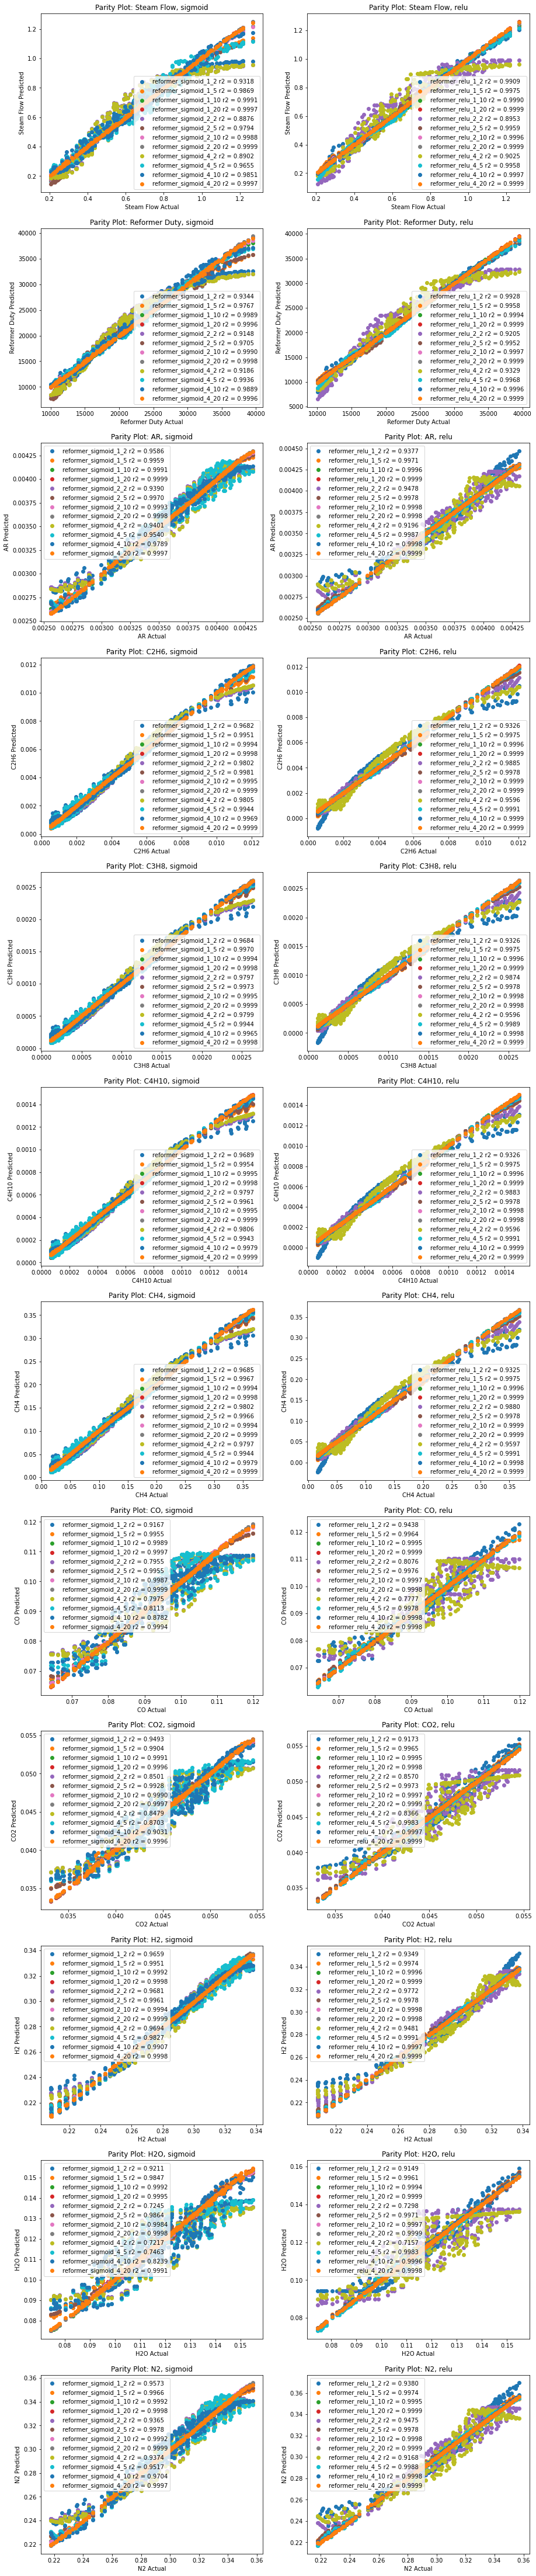

In [66]:
from sklearn.metrics import r2_score
# Create Graphs
fig, axs = plt.subplots(len(outputs),len(activation_list), figsize = (15,80))

# Grab and graph the data vs y_test
for j, act in enumerate(activation_list):
    for layers in hidden_layers_list:
        for nodes in nodes_list:

            # Create NN and name it
            nn_name = 'reformer_{}_{}_{}'.format(act,layers,nodes)

            # Grab Data
            df = pd.read_excel('Book1.xlsx', sheet_name=nn_name+'_yh')
            for i, output in enumerate(outputs):
                r2 = r2_score(y_test[output], df[output])
                axs[i,j].scatter(y_test[output], df[output], label = '{} r2 = {:.4f}'.format(nn_name,r2))

#Create labels and titles for graphs
for i, output in enumerate(outputs):
    for j, act in enumerate(activation_list):
        axs[i,j].legend()
        axs[i,j].set_xlabel('{} Actual'.format(output))
        axs[i,j].set_ylabel('{} Predicted'.format(output))
        axs[i,j].set_title("Parity Plot: {}, {}".format(output, act))

### Plot of "stats_df"
- Want to see how NN architecture affected the optimum results from Pyomo.
- We don't have a "ground truth" for this case study.
- Did a certain NN's agree with each other? Which ones tended to agree? Which ones tended to be the most different?
- Do you think that the results were good relative to the computational time it takes?
    - What seems to be the optimal size / structure based on agreement of outputs with other models and also regarding time?

In [58]:
stats_df

,reformer_sigmoid_1_2,reformer_sigmoid_1_5,reformer_sigmoid_1_10,reformer_sigmoid_1_20,reformer_sigmoid_2_2,reformer_sigmoid_2_5,reformer_sigmoid_2_10,reformer_sigmoid_2_20,reformer_sigmoid_4_2,reformer_sigmoid_4_5,...,reformer_relu_1_10,reformer_relu_1_20,reformer_relu_2_2,reformer_relu_2_5,reformer_relu_2_10,reformer_relu_2_20,reformer_relu_4_2,reformer_relu_4_5,reformer_relu_4_10,reformer_relu_4_20
Optimum Bypass Fraction,0.169919,0.100000,0.100000,0.100000,0.201152,0.100000,0.100000,0.100000,0.187940,0.244258,...,0.100000,0.100000,0.169105,0.100000,0.100000,0.100000,0.320287,0.100000,0.100000,0.100000
Optimum NG Steam Ratio,1.199996,1.080267,1.116719,1.118287,1.036982,1.105557,1.122386,1.111596,1.058752,1.199755,...,1.135489,1.127108,0.800000,1.169390,1.138136,1.110915,1.200000,1.144919,1.136968,1.123729
Maximum H2 Output,0.329038,0.333327,0.331992,0.331699,0.327983,0.333075,0.331966,0.331161,0.327713,0.328730,...,0.332323,0.332397,0.327299,0.333440,0.331571,0.331888,0.327781,0.332306,0.332153,0.332024
Maximum N2 Output,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,...,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000,0.340000
Time of Computation,4.831046,4.273208,4.810357,5.017930,4.726501,4.799134,5.173570,5.970437,5.565205,5.917688,...,6.023253,6.778022,6.495798,6.712106,6.921217,8.054362,7.571008,7.839612,7.689789,16.527646


In [60]:
headers

['Optimum Bypass Fraction',
 'Optimum NG Steam Ratio',
 'Maximum H2 Output',
 'Maximum N2 Output',
 'Time of Computation']

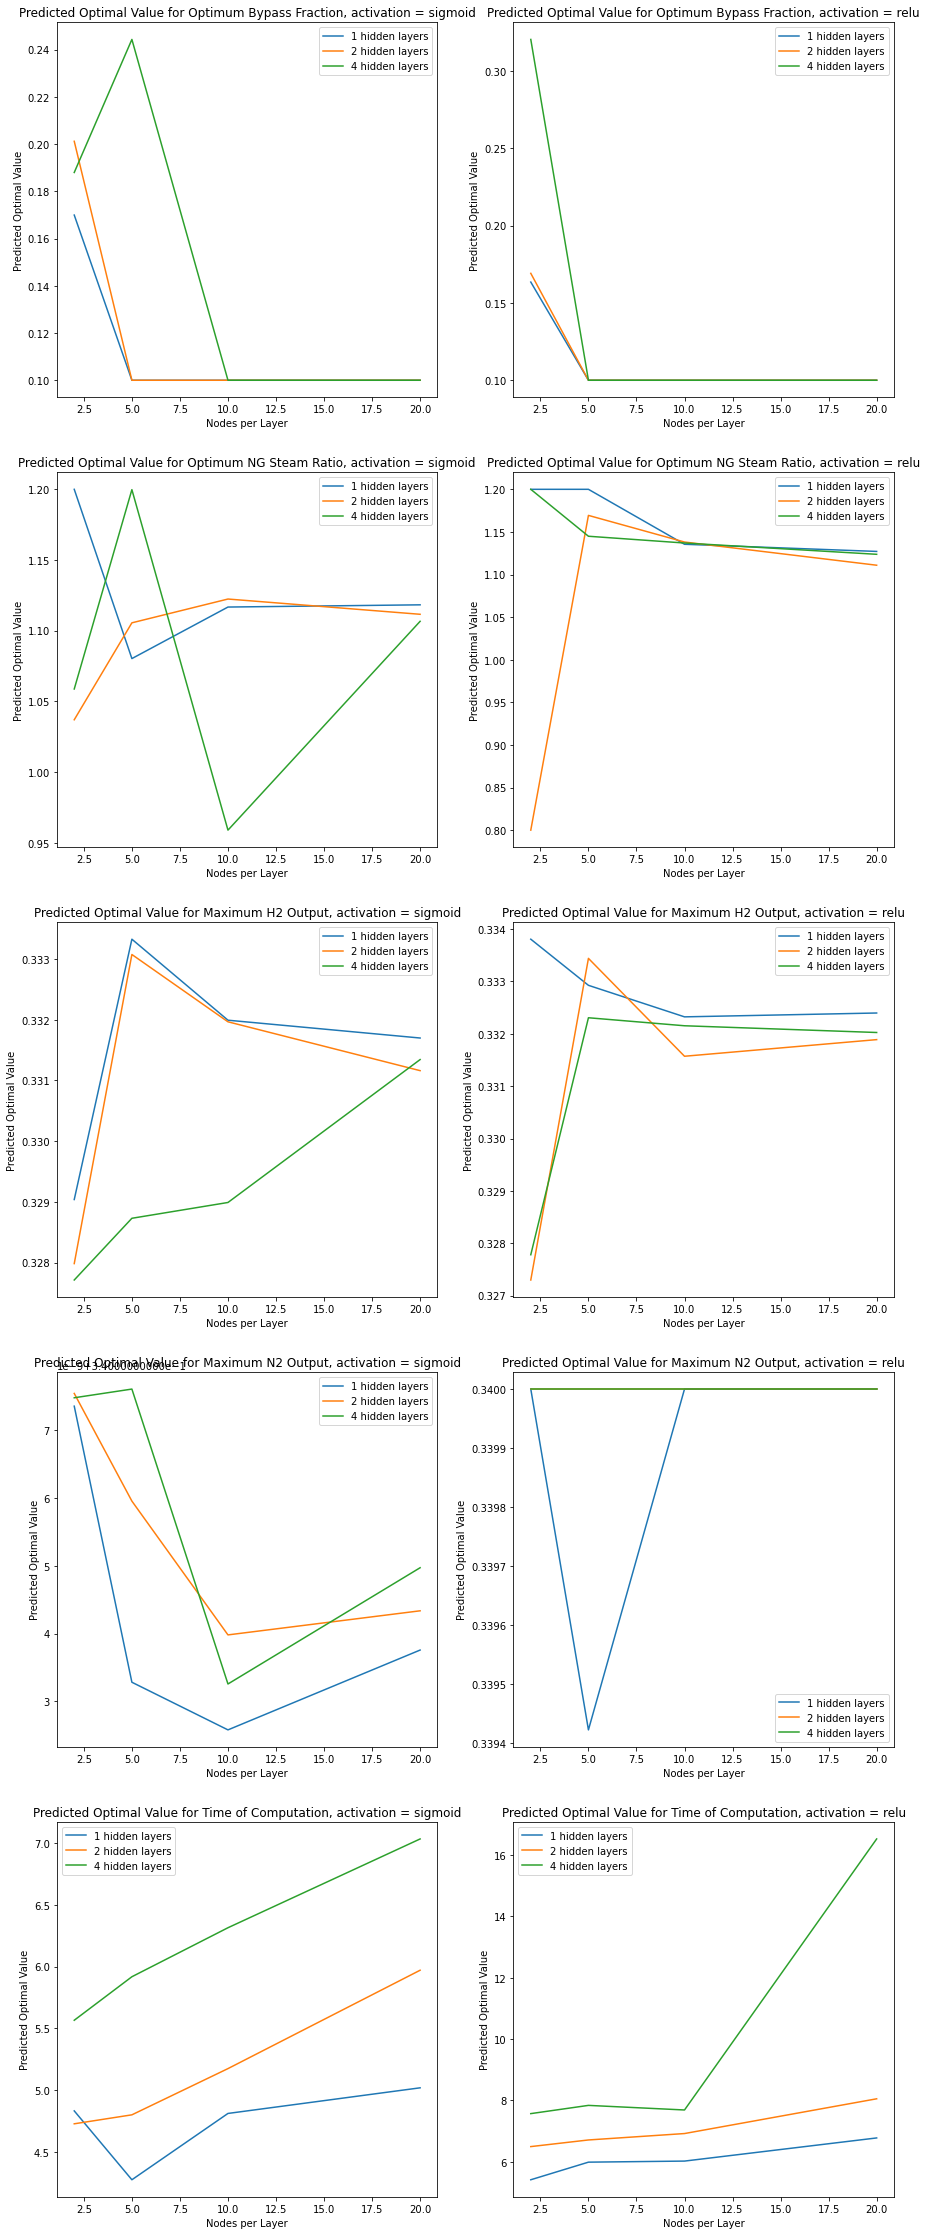

In [65]:
# Create Graphs
fig, axs = plt.subplots(len(headers),len(activation_list), figsize = (15,40))

# Grab and graph the data vs y_test
for j, act in enumerate(activation_list):
    for i, header in enumerate(headers):
        for layers in hidden_layers_list:
            stat = []
            for nodes in nodes_list:

                # Create NN and name it
                nn_name = 'reformer_{}_{}_{}'.format(act,layers,nodes)

                # Grab Data
                stat.append(stats_df[nn_name][header])
            
            axs[i,j].plot(nodes_list, stat, label = '{} hidden layers'.format(layers))

#Create labels and titles for graphs
for i, header in enumerate(headers):
    for j, act in enumerate(activation_list):
        axs[i,j].legend()
        axs[i,j].set_xlabel('Nodes per Layer')
        axs[i,j].set_ylabel('Predicted Optimal Value')
        axs[i,j].set_title("Predicted Optimal Value for {}, activation = {}".format(header, act))